# Ensemble Learning

Models we have discussed previously:
- Linear regression. 
- Logistic regression.  
- Decision trees.  
- k-Nearest neighbors.  
- Support vector machines.  

Sometimes these models are too simple (even tuned) to provide a model accurate enough to be worth putting into production, especially compute and infrastructure requirements.

Another approach is ensemble learning - instead of trying to make a single model that has sufficient performance, maybe using multiple models and combining the results in some way will lead to better overall performance.

This will generally follow Python Machine Learning 3rd Edition, Chapter 7.

<img src='files/diagrams/modelstacking.png' style='width: 500px'>

[Image source: SAS Blog](https://blogs.sas.com/content/subconsciousmusings/2017/05/18/stacked-ensemble-models-win-data-science-competitions/)

<div class="alert alert-block alert-success"><b>Why bother? </b> A set of classifiers will often have better predictive performance than the individual members. </div>

Think of a chorus of young students. Many will sing too low or too high, but on average they sound better together than individually. 

### Goal
> Combine different classifers into a meta-classifier that has better generalization performance than each individual classifier alone.
<br><br>Machine Learning with Python 3rd Edition, Page 223.

Ask a panel of medical experts about health issues. For the common topics, they will have a tendency to agree. For rarer topics, the specialists, which there are fewer, will be more knowledgeable. The non-specialists opinions for those rare topics will probably be all over the place, but the specialist opinions will likely be in agreement.

Sometimes these are also referred to as **meta-models.**

The most common underlying models for these are weak decision trees, sometimes stumps, sometimes referred to as **weak learners**.  
- Computationally pretty fast.  
- Trees aren't identical and will be better than random guessing.  
- Can obtain high accuracy with many of these independent trees, similar in concept to random forests.  
- We aren't restricted to trees though, any classifier (regression) can be used to create ensembles.  

### Common methods
- Majority voting. 
- Bagging. 
- Boosting.  

# Majority Voting
> Really talking about the plurality or mode. Majority doesn't generalize for multi-class problems.

<img src='files/diagrams/unaminity-majority-plurity.png' style='width: 500px'>

[Image source: Machine Learning with Python 3rd Edition, Figure 7.1](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch07)

 </div> <div class="alert alert-block alert-success"><b>Random Forests: </b> We've already encountered an ensemble model, random forests. Recall a random forest is a collection of individual decision trees, with the prediction being the plurality class predicted from the $C$ individual trees. </div>

<img src='files/diagrams/majorityvoting.png' style='width: 500px'>

[Image source: Machine Learning with Python 3rd Edition, Figure 7.2](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch07)

- $C$ different classification algorithms can be fit.  
- These can include different models, different parameter settings, different feature processing, ...   

<div class="alert alert-block alert-warning"><b>Warning: </b> While these can be useful, for larger datasets and models that are computationally intensive by themselves, ensembles can be very expensive. </div>

### Predicting the label ($mode=plurality$)
$$
\hat{y} = mode(C_1(x), C_2(x), \dots, C_m(x))
$$

### Rationale
Assuming we have $n$ binary classifiers that are independent and the error rates are uncorrelated, the errors can be expressed as a probability mass function of a binomial distribution.

$$
P(y\geq k) = \sum_k^n {n \choose k}\epsilon^k(1-\epsilon)^{n-k}=\epsilon_{ensemble}
$$

i.e., compute the probability that the prediction is wrong. For 11 classifers ($n$) with error rates of 0.25, with a majority being 6 ($k$):
$$
P(y\geq k) = \sum_6^{11} {11 \choose k}0.25^k(1-0.25)^{11-k}=0.034
$$

> Assuming the classifiers are (1) independent with (2) uncorrelated errors; the error rate with the ensemble is much lower than the individual error rates ($0.034 \lt 0.25$).

### Does it always work?
No. In the class of binary classifiers, the classifiers have to do better than random guessing. [The below code is from page 226-227 of Machine Learning with Python](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch07).

In [1]:
from scipy.special import comb
import math

def ensemble_errors(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * (error ** k) * (1 - error)**(n_classifier - k)
            for k in range(k_start, n_classifier+1)
            ]
    return sum(probs)

example_ensemble_error = ensemble_errors(n_classifier=11, error=0.25)
print(f'Error rate: {example_ensemble_error:.2%}')

Error rate: 3.43%


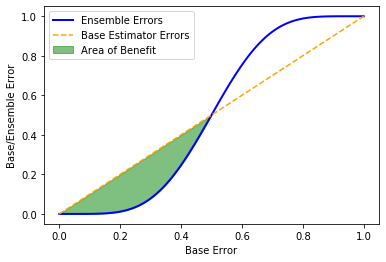

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_errors(n_classifier=11, error=error) for error in error_range]

plt.plot(error_range, ens_errors, label='Ensemble Error', color='blue', linewidth=2)
plt.plot(error_range, error_range, label='Base Error', linestyle='--', color='orange')
plt.fill_between(error_range[:51], ens_errors[:51], error_range[:51], color='green', alpha=0.5)
plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble Error')
plt.legend(['Ensemble Errors', 'Base Estimator Errors', 'Area of Benefit'])
plt.show()

### Weighting Classifiers
There is an extension that is implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) that allows you to weight each classifier with an arbitrary weight.

$$
\hat{y}=argmax{_t} \sum_j^k w_j\chi_A(C_j(x)=i)
$$

$w_j$ is a weight associated with the base classifier, $C_j$; $\hat{y}$ is the predicted label; $A$ is the set of unique class labels; $\chi_A$ is the indicator function that determines the class within the classifier.

If you had $3$ classifiers and $w_{j's}=\in (0.6, 0.2, 0.2)$, you would effectively be counting the first classifier's label $3$ times, the second classifier once, and the third classifier once.

$$
\{C_1=1, C_2=0, C_3=0 \} \rightarrow  (1,1,1,0,0)
$$

For the probabilities (`predict_proba`) it is the weighted average of the individual probabilties:

$$
\hat{y}=argmax{_t} \sum_j^k w_jp_{i,j}
$$

Assuming we have $3$ binary classifiers, returning the following probabilities for an example:

$$
C_1(x) \rightarrow [0.9, 0.1], C_2(x) \rightarrow [0.8, 0.2], C_3(x) \rightarrow [0.4, 0.6]
$$

Using the same weights, we would have:
$$
p(i_0|x) = 0.6\times0.9 + 0.2\times0.8 + 0.2\times0.4 = 0.78
$$

$$
p(i_1|x) = 0.6\times0.1 + 0.2\times0.2 + 0.2\times0.6 = 0.22
$$

And the overall result is:
$$\hat{y} = argmax{_t}[p(i_0|x),p(i_1|x)] = argmax{_t}[0.78, 0.22]= 0$$

<div class="alert alert-block alert-warning"><b>Not all probabilties are created equal: </b> Although we can weight the probabilities, they may not be calculated the same way. Recall decision tree probabilties are essentially the class distributions on the leafs and other models produce probabilties from probability mass functions. </div>
 
 ### Regression
 For regression, it is a bit simpler. Weight the individual $\hat{y}$ values to obtain a weighted average estimate and recalcuate the $r^2$ or other scoring metrics.

## Classification with Majority Voting on `iris`

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:,]

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 60
Test examples: 40


- Logistic regression,  
- Decision tree, and  
- k-nearest neighbors

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([('scaler', StandardScaler()),('logreg', clf1)])
pipe2 = Pipeline([('scaler', StandardScaler()),('tree', clf2)])
pipe3 = Pipeline([('scaler', StandardScaler()),('knn', clf3)])

labs = ['Logistic Regression', 'Decision Tree', 'k-Nearest Neighbors']
clfs = [pipe1, pipe2, pipe3]
clfs = zip(labs, clfs)

for lab, clf in clfs:
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC {scores.mean():.2f} (+/- {scores.std():.2f}) [{lab}]')

ROC AUC 0.95 (+/- 0.08) [Logistic Regression]
ROC AUC 0.93 (+/- 0.08) [Decision Tree]
ROC AUC 0.93 (+/- 0.11) [k-Nearest Neighbors]


VotingClassifier from scikit-learn.
- Set `voting=soft` to use the probabilities to inform the class prediction. `voting=hard` will use the mode of the predicted classes.

In [5]:
from sklearn.ensemble import VotingClassifier

ems = [('lr', pipe1),('dt', pipe2),('knn', pipe3)]
clf4 = VotingClassifier(estimators= ems, weights=None, voting='soft')

scores = cross_val_score(estimator=clf4, X=X_train, y=y_train, cv=10, scoring='roc_auc')
print(f'ROC AUC {scores.mean():.2f} (+/- {scores.std():.2f}) [Ensemble]')

ROC AUC 0.99 (+/- 0.03) [Ensemble]


<div class="alert alert-block alert-success"><b>Higher area under the curve, with smaller variations between the folds! That was on the training though, need to evaluate on the test data.</div>

### Recall [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- We can tune a VotingClassifier the same we way tune individual ones.

In [6]:
clf4

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('logreg',
                                               LogisticRegression(C=0.001,
                                                                  random_state=0))])),
                             ('dt',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('tree',
                                               DecisionTreeClassifier(criterion='entropy',
                                                                      max_depth=1,
                                                                      random_state=1))])),
                             ('knn',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier(n_

In [7]:
from sklearn.model_selection import GridSearchCV

params = {'lr__logreg__C':[0.001, 0.1, 1, 10], 
          'dt__tree__max_depth': [1,2,3], 
          'knn__knn__n_neighbors': [1,2,3]
         }

vc_gs = GridSearchCV(estimator=clf4, param_grid=params, scoring='roc_auc', refit=True)
vc_gs = vc_gs.fit(X_train, y_train)
vc_gs_score = vc_gs.score(X_test, y_test)

print(f'VotingClassifier Test ROC AUC: {vc_gs_score:.2%}')

VotingClassifier Test ROC AUC: 96.21%


# Bagging (also known as Bootstrap Aggregating)
- Another ensemble learning technique, similar to the VotingClassifier.  
- Instead of using the same dataset for training, bootstrap samples are drawn.  
- Aggregation should reduce bias and variation in our results.  

<img src='files/diagrams/bootstrap-samples.png' style='width: 500px'>

[Image source: Machine Learning with Python 3rd Edition, Figure 7.6](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch07)

> This can improve accuracy and decrease overfitting when models are unstable. [See Breiman's paper on bagging.](https://www.stat.berkeley.edu/~breiman/bagging.pdf)

> Bagging won't help with bias or underfitting models. These are commonly used with unpruned decision trees, which by themselves are very prone to overfitting.

#### Logistic Regression as Benchmark

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=0)
pipe1 = Pipeline([('scaler', StandardScaler()),('logreg', clf1)])

params = {'logreg__C':[0.001, 0.1, 1, 10]}

lrcv = GridSearchCV(pipe1, param_grid=params, cv=10, scoring='roc_auc')
lrcv = lrcv.fit(X_train, y_train)
lrcv.score(X_test, y_test)

0.9671717171717171

In [9]:
lrcv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(C=10, random_state=0))])

Average deviation on test scores:

In [10]:
lrcv.cv_results_['std_test_score'].mean()

0.04376606821787728

#### Bagging:

In [11]:
from sklearn.ensemble import BaggingClassifier

dt = DecisionTreeClassifier()
bclf = BaggingClassifier(dt)

params = {'base_estimator__max_depth':[1, 2, 4, 6], 'max_samples':[0.1, 0.2, 0.3, 0.4, 0.5]}

blrcv = GridSearchCV(bclf, param_grid=params, cv=10, scoring='roc_auc')
blrcv = blrcv.fit(X_train, y_train)
blrcv.score(X_test, y_test)

0.936868686868687

Average deviation of test scores:

In [12]:
blrcv.cv_results_['std_test_score'].mean()

0.02534637521276656

> `iris` is pretty stable, so no benefit, but you can try bagging if overfitting seems to be an issue. However, we do see lower standard deviations in the test scores across the folds - less bias in bagging.

#### Takeaways
- Performance was about the same with bagging.  
- Variance likely lower in our estimates.

# Adaptive Boosting (AdaBoost)
- Boosting refers to ensembles that combine weak learners into a strong learner. 
- Generally, the weak decision trees are used as the learner.  
- Generally, we sequentially train weak models and the subsequent try to correct the prior model's mistakes.  
- AdaBoost and Gradient Boosting are the most popular.  
- Since the learners are dependent on previous learners, this is not able to be parallelized and won't scale as well as bagging.  

### Original Process
- Draw random subset of examples, $d_1$, without replacement, and train a weak learner, $C_1$.  
- Draw second sample, $d_2$, and add 50% of samples that were misclassified in $C_1$ to a second weak learner, $C_2$.  
- Find examples, $d_3$ that $C_1$ and $C_2$ disagreed on and train another weak learner, $C_3$.  
- Combined $C_1$, $C_2$, and $C_3$ via majority voting.  

### New Process
Newer process work much in the same way as above, except all examples are used in each learner and those misclassified are weighted heavier.

In the image below:
1. Represents the initial learner with all examples, equal-weighted.  
2. Assign larger weight to misclassified examples from first learner (bigger circles) and train another learner.  3. Assign yet larger weights to misclassified examples from second learner and train another learner.  
4. Combine three learners by weighted majority vote.  

<img src='files/diagrams/adaboost.png' style='width: 600px'>

[Image source: Machine Learning with Python 3rd Edition, Figure 7.9](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch07)
    
 

#### Pseudo Code

- Set weight vector, $w$, to uniform weights, $\sum_iw_i=1$.  
- For $j$ in $m$ boosting rounds:
    - Train a weak learner: $C_j=train(X,y,w)$.  
    - Predict labels: $\hat{y}=predict(C_j,X)$.  
    - Compute weighted error rate: $\epsilon=w(\hat{y}\ne y)$.  
    - Compute coefficient: $\alpha_j=0.5log\frac{1-\epsilon}{\epsilon}$  
    - Update weights: $w:=w\times exp(-\alpha_j x \hat{y} \times y)$  
    - Normalize weights: $w:=w/\sum_iw_i$  
- Compute final predictions:
$$
\hat{y}=\sum{_{j=1}^{m}}(\alpha_j \times predict(C_j,X)>0)
$$

#### Wine Example
Data from [UCI's Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Wine).

In [13]:
import pandas as pd

wine = pd.read_csv('data/wine.data', header=None)

wineCols = ['Class label', 'Alcohol', 'Malic Acid', 'Ash', 'Alcalinity of Ash',
           'Magnesium', 'Total Phenols', 'Flavanoid', 'Nonflavanoid Phenols',
           'Proanthocyanins', 'Color Intensity', 'Hue', 'OD280-OD315', 'Proline']

wine.columns = wineCols

wine.head()

,Class label,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoid,Nonflavanoid Phenols,Proanthocyanins,Color Intensity,Hue,OD280-OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [14]:
wine['Class label'].value_counts()

2    71
1    59
3    48
Name: Class label, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

wineFeatures = [x for x in wineCols if x != 'Class label']
wineX = wine[wineFeatures]
winey = wine['Class label']

wX_train, wX_test, wy_train, wy_test = train_test_split(wineX, winey, test_size=0.3)

print(f'Training examples: {wX_train.shape[0]}')
print(f'Test examples: {wX_test.shape[0]}')

Training examples: 124
Test examples: 54


#### Determine performance on Decision Tree Stumps ($depth=1$)

In [16]:
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)
tree = tree.fit(wX_train, wy_train)
tree_train_predict = tree.predict(wX_train)
tree_test_predict = tree.predict(wX_test)

tree_train_score = accuracy_score(wy_train, tree_train_predict)
tree_test_score = accuracy_score(wy_test, tree_test_predict)

print(f'Tree Training Score: {tree_train_score:.2%}')
print(f'Tree Test Score: {tree_test_score:.2%}')

Tree Training Score: 63.71%
Tree Test Score: 50.00%


#### Use AdaBoost, with the Stump Decision Tree as the base estimator

In [17]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
ada = ada.fit(wX_train.values, wy_train)
ada_train_predict = ada.predict(wX_train.values)
ada_test_predict = ada.predict(wX_test.values)

ada_train_score = accuracy_score(wy_train, ada_train_predict)
ada_test_score = accuracy_score(wy_test, ada_test_predict)

print(f'AdaBoost Training Score: {ada_train_score:.2%}')
print(f'AdaBoost Test Score: {ada_test_score:.2%}')


AdaBoost Training Score: 98.39%
AdaBoost Test Score: 83.33%


> AdaBoost perfectly assigns all the training data. Probably overfitting - see the drop in the test score. Want would to run through cross-validation to ensure stability of those high scores. The absolute gap is bigger in the AdaBoost classifier, so we introduced additional model bias.

**AdaBoost Hyperparameters to Tune:**  
- Number of estimators. 
- Learning rate.  

# Gradient Boosting
Similar to AdaBoost, in that it sequentially adds learners to an ensemble. Instead of changing weights after after iteration, this tires to fit the new predictor to the residual errors made by the previous learner.

Example from [Hands on Machine Learning with Scikit-Learn, Keras & TensorFlow, pages 204-205](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb)

Generate quadratic data with a little noise:

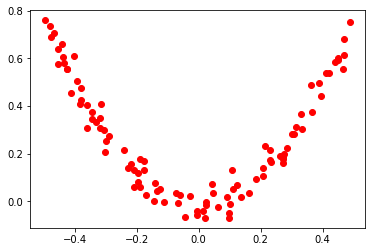

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

plt.plot(X,y, 'ro')
plt.show()

#### Train an initial weak Regression Tree

In [19]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

#### Calculate residuals and use those as the target variable in another weak Regression Tree

In [20]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

#### Calculate residuals and use those as the target variable in another weak Regression Tree

In [21]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

#### New predictions can be made by summing up the residuals from the three trees

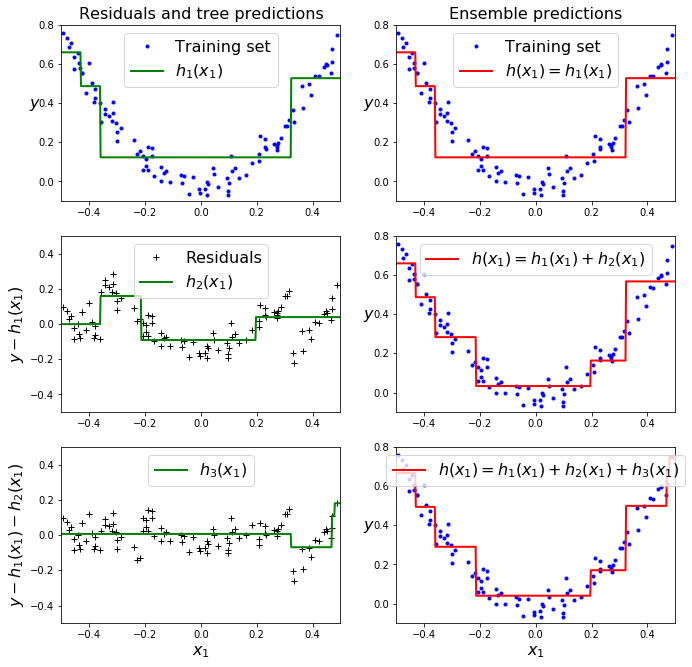

In [22]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

#### scikit-learn Equivalent:

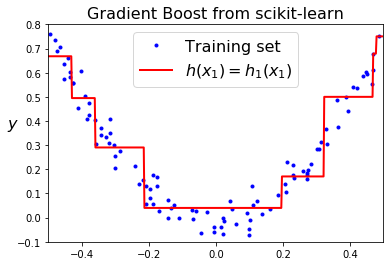

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt = gbrt.fit(X, y)

plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Gradient Boost from scikit-learn", fontsize=16)
plt.show()

#### Sensitivity of Learning Rates and Estimators

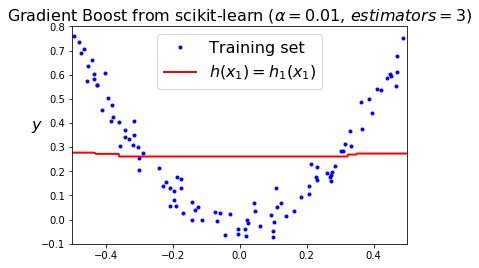

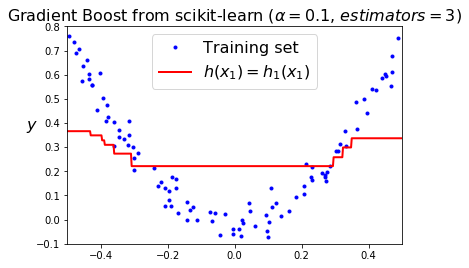

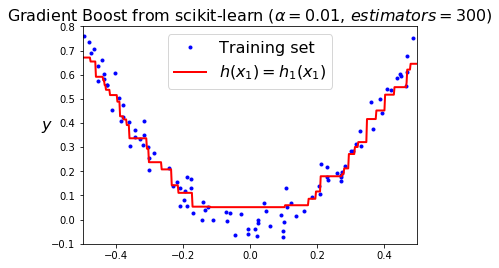

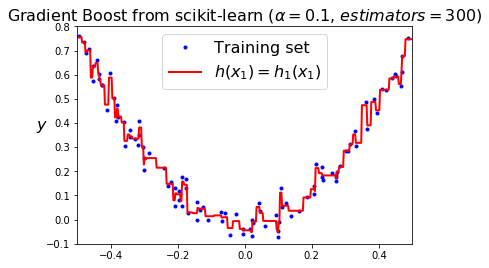

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.01)
gbrt = gbrt.fit(X, y)

plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Gradient Boost from scikit-learn ($\\alpha=0.01$, $estimators=3$)", fontsize=16)
plt.show()

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1)
gbrt = gbrt.fit(X, y)

plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Gradient Boost from scikit-learn ($\\alpha=0.1$, $estimators=3$)", fontsize=16)
plt.show()

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=300, learning_rate=0.01)
gbrt = gbrt.fit(X, y)

plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Gradient Boost from scikit-learn ($\\alpha=0.01$, $estimators=300$)", fontsize=16)
plt.show()

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=300, learning_rate=0.1)
gbrt = gbrt.fit(X, y)

plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Gradient Boost from scikit-learn ($\\alpha=0.1$, $estimators=300$)", fontsize=16)
plt.show()



- Learning rate affects the contributions from each tree. Lower values will require more trees, but generalization will be better (shrinkage).  
- Increasing the number of trees can lead to overfitting. Use early stopping to determine an optimal number of trees. Early stopping looks at the validation errors as the number of trees increase.  

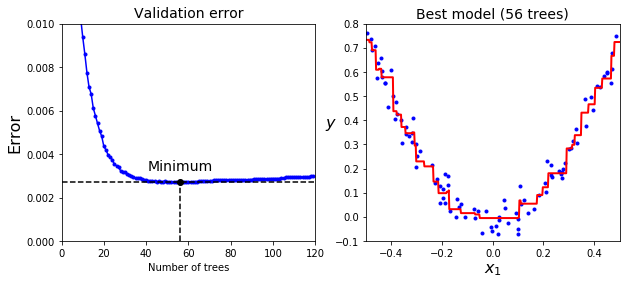

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

min_error = np.min(errors)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

# More tangible example using customer churn data

In [26]:
tel = pd.read_csv('data/telco.csv')

tel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Churn distribution

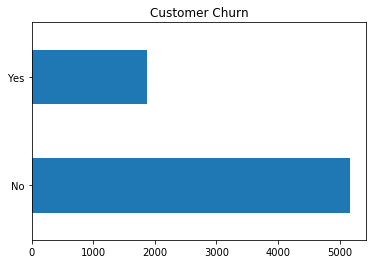

In [27]:
tel.Churn.value_counts().plot.barh()
plt.title('Customer Churn')
plt.show()

- Unbalanced, but not as severe as when seen before.

#### Cardinality Check

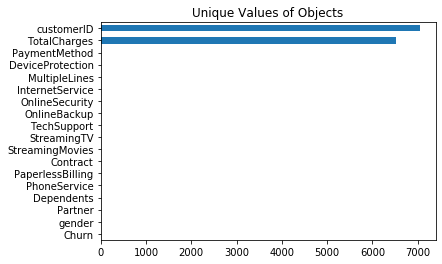

Churn                  2
gender                 2
Partner                2
Dependents             2
PhoneService           2
PaperlessBilling       2
Contract               3
StreamingMovies        3
StreamingTV            3
TechSupport            3
OnlineBackup           3
OnlineSecurity         3
InternetService        3
MultipleLines          3
DeviceProtection       3
PaymentMethod          4
TotalCharges        6531
customerID          7043
dtype: int64

In [28]:
tel.select_dtypes('object').nunique().sort_values().plot.barh()
plt.title('Unique Values of Objects')
plt.show()

tel.select_dtypes('object').nunique().sort_values()

- customerID is something we won't want to use for modeling.  
- TotalCharges might have an incorrect type.

In [29]:
tel.TotalCharges.head()

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: object

In [30]:
tel['TotalCharges'] = pd.to_numeric(tel['TotalCharges'], errors='coerce')
tel['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

#### Numerical Columns

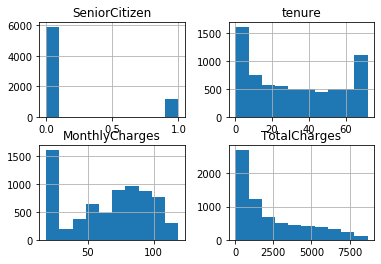

In [31]:
tel.select_dtypes(['int64','float64']).hist()
plt.show()

- SeniorCitizen looks like a dummy. 
- tenure and MonthlyCharges seem to be truncated to some degree.

#### Missing value check

In [32]:
tel.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

- Will need an imputer; missing values likely caused by the type conversion.  
- If there were a substantial amount of NAs due to the type conversion, we may have to handle it more elegantly, especially if the data generation process will allow this field to come in as objects.

# Plan
- Baseline with logistic regression.  
- Create a straight decision tree.  
- AdaBoost.  
- GradientBoost.  

We'll use `accuracy` as a metric, but you could make the arguement recall may be what we'd want to optimize for since we could proactively reach-out to those customers and try to get them to stay on the service with discounts or other incentives.

In [34]:
nums = tel.dtypes[tel.dtypes != 'object'].index.tolist()

cats = tel.dtypes[tel.dtypes == 'object'].index.tolist()
cats = [x for x in cats if x not in ['Churn', 'customerID']]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])

cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, nums),
                                                      ('create_dummies', cat_pipeline, cats)])

print('Pipeline Created')

Pipeline Created


#### Split Data

In [35]:
from sklearn.model_selection import train_test_split

y = np.where(tel.Churn == 'Yes', 1, 0)

tX_train, tX_test, ty_train, ty_test = train_test_split(tel[nums+cats],
                                                       y,
                                                       test_size=0.2
                                                       )

print(f'Training examples: {tX_train.shape[0]:,}')
print(f'Test examples: {tX_test.shape[0]:,}')

Training examples: 5,634
Test examples: 1,409


#### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

p1 = Pipeline([('processing', processing_pipeline),
             ('lr', LogisticRegression(solver='liblinear'))])

params = {'lr__C': [0.01, 0.1, 1, 10]}

lr_gscv = GridSearchCV(p1, param_grid=params, cv=10, scoring='accuracy', refit=True)
lr_gscv = lr_gscv.fit(tX_train, ty_train)

print(f'Validation score: {lr_gscv.best_score_:.2%}')

lr_pred = lr_gscv.predict(tX_test)

print(f'Test score: {lr_gscv.score(tX_test, ty_test):.2%}')

Validation score: 80.80%
Test score: 80.34%


#### Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

p2 = Pipeline([('processing', processing_pipeline),
             ('dt', DecisionTreeClassifier())])

params = {'dt__max_depth': [1, 5, 10, 15, 25],
         'dt__min_samples_split': [3, 10, 15]}

dt_gscv = GridSearchCV(p2, param_grid=params, cv=10, scoring='accuracy', refit=True)
dt_gscv = dt_gscv.fit(tX_train, ty_train)

print(f'Validation score: {dt_gscv.best_score_:.2%}')

dt_pred = dt_gscv.predict(tX_test)

print(f'Test score: {dt_gscv.score(tX_test, ty_test):.2%}')

Validation score: 79.27%
Test score: 79.35%


#### AdaBoost

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# multi-step pipelines don't play as nice with AdaBoost
xt = processing_pipeline.fit_transform(tX_train)

params = {'base_estimator__max_depth': [1,2],
         'n_estimators': [50, 100, 200, 400]
         }

#ABC = AdaBoostClassifier(base_estimator=p2)
ABC = AdaBoostClassifier(DecisionTreeClassifier())


ad_gscv = GridSearchCV(ABC, param_grid = params, cv=10, scoring='accuracy')
           
ad_gscv = ad_gscv.fit(xt, ty_train)

print(f'Validation score: {ad_gscv.best_score_:.2%}')

xtt = processing_pipeline.transform(tX_test)

ad_pred = ad_gscv.predict(xtt)

print(f'Test score: {ad_gscv.score(xtt, ty_test):.2%}')

Validation score: 80.48%
Test score: 80.70%


#### Gradient Boosting

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

p3 = Pipeline([('processing', processing_pipeline),
             ('gb', GradientBoostingClassifier())])

params = {'gb__max_depth': [1,2,3],
         'gb__n_estimators': [50, 100, 200]
         }

gb_gscv = GridSearchCV(p3, param_grid = params, cv=10, scoring='accuracy')
           
gb_gscv = gb_gscv.fit(tX_train, ty_train)

print(f'Validation score: {gb_gscv.best_score_:.2%}')

gb_pred = gb_gscv.predict(tX_test)

print(f'Test score: {gb_gscv.score(tX_test, ty_test):.2%}')

Validation score: 80.60%
Test score: 80.34%


In [40]:
print(f'Logistic Regression: {lr_gscv.score(tX_test, ty_test):.2%}')
print(f'Decision Tree: {dt_gscv.score(tX_test, ty_test):.2%}')
print(f'AdaBoost: {ad_gscv.score(xtt, ty_test):.2%}')
print(f'Gradient Boosting: {gb_gscv.score(tX_test, ty_test):.2%}')

Logistic Regression: 80.34%
Decision Tree: 79.35%
AdaBoost: 80.70%
Gradient Boosting: 80.34%


# Wrap-up

- Ensembles can reduce bias and potentially increase performance.  
- Usually a trade-off with computational complexity.  
- Plenty of examples in real life where an ensemble performed the best, but it was impractical to implement. See the [example with the Netflix prize.](https://www.netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf)  
- Sometimes, but not always, helps performance.

# Readings
- [XGBoost - optimized version of Gradient Boosting](https://xgboost.readthedocs.io/en/latest/)  
- [Netflix Model](https://www.netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf)